In [115]:
import math
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch

warnings.filterwarnings('ignore')

In [116]:
df = sb.events(match_id=3869685).sort_values(by=['index'])

df = df[df['period'] < 5] # Remove any data from penalty shootouts

In [117]:
team1 = df[df['team'] == 'Argentina']
team2 = df[df['team'] == 'France']

In [118]:
FRANCE_COLOR = '#002654'
ARGENTINA_COLOR = '#43A1D5'

ARGENTINA_TEAM_ID = 779
FRANCE_TEAM_ID = 771

In [119]:
df  = df[df['period'] < 5]

In [120]:
#shotmap visualization
def create_shotmap(team, ax):
    pitch = VerticalPitch(pitch_type='statsbomb', half=True)
    pitch.draw(ax=ax)
    
    # the shots data is in the 'type' column
    team = team[team['type']=='Shot']
    
    # Filter down to just the columns we need
    team = team[['team', 'player', 'location', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type']]
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    # Draw the shotmap
    for x in team.to_dict(orient='records'):
        pitch.scatter(
            x=x['x'], y=x['y'], ax=ax, 
            s=500 * x['shot_statsbomb_xg'], 
            color='green' if x['shot_outcome'] == 'Goal' else 'white', 
            edgecolors='black', alpha=0.7
        )

In [121]:
def create_passnetwork(team, ax):
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    tactics = team[~team['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Make a new, single column for time and sort the events in chronological order
    team["newsecond"] = 60 * team["minute"] + team["second"]
    
    team.sort_values(by=['newsecond'])
    
    # identify the passer and then the recipient, who'll be the playerId of the next action
    team['passer'] = team['player_id']
    
    team['recipient'] = team['passer'].shift(-1)
    
    # filter for only passes and then successful passes
    passes_df = team.loc[(team['type']=="Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    
    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
    
    #find time of the team's first substitution and filter the df to only passes before that
    sub_df = team.loc[(team['type'] == "Substitution")]
    first_sub = sub_df["newsecond"].min()
    
    if first_sub <= (60 * 45):
        first_sub = 60 * 45
    
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
    average_locs_and_count.columns = ['x', 'y', 'count']
    
    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )
    
    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
    # plot arrows
    def pass_line_template(ax, x, y, end_x, end_y, line_color):
        ax.annotate(
            '',
            xy=(end_y,  end_x),
            xytext=(y, x),
            zorder=1,
            arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
        )
        
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y-y, end_x-x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='grass', line_color='white', stripe=True)
    pitch.draw(ax=ax)
    
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
    # plot nodes
    pitch.scatter(
        average_locs_and_count.x, average_locs_and_count.y, s=500,
        color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
    )
    
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(
            jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
            xy=(row.x, row.y),
            c='#132743',
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=ax
        )

In [122]:
def create_table(team1, team2):
    # Drop rows where the pass_outcome is Unknown
    team1 = team1[team1['pass_outcome'] != 'Unknown']
    team2 = team2[team2['pass_outcome'] != 'Unknown']
    
    # Create a table with the data
    # We first need to calculate the statistics for each team
    # we will calcualte the following stats:
    # - goals
    # - xG
    # - shots
    # - shots on target
    # - passes
    # - pass completion %
    
    # Create a dictionary to store the stats
    stats = {
        'goals': {'team1': len(team1[team1['type'] == 'Goal']), 'team2': len(team2[team2['type'] == 'Goal'])},
        'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
        'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
        'shots_on_target': {
            'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
            'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
        },
        'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
        'pass_completion': {
            'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
            'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
        }
    }
    
    # store as a dataframe
    stats_df = pd.DataFrame(stats).T

    column_labels = ['', '', '']
    table_vals = [
        [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
        [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
        [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
        [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
        [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
    ]
    
    return column_labels, table_vals

In [123]:
def create_xg_flow_chart(df, ax):
    # We'll use the original df instead of the team1 and team2 dataframes
    
    # Filter the columns to only shots
    df = df[df['type'] == 'Shot']
    
    # Sort the values so they are in order of time
    df = df.sort_values(by="index")
    
    # Calculate the cumulative xG for each team
    df['cumulative_xG'] = df.groupby('team_id')['shot_statsbomb_xg'].cumsum()
    
    # Plot the xG for each team by half
    # We want to make it so the lines both start at 0
    for team in df['team_id'].unique():
        
        team_df = df[df['team_id'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({
            'team_id': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': None, 'cumulative_xG': 0, 'period': 1
        }, index=[0]), team_df])
        
        ax.plot(
            team_df['minute'], 
            team_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=ARGENTINA_COLOR if team == ARGENTINA_TEAM_ID else FRANCE_COLOR
        )   
            
    
    # We Can add a scatter plot to show the goals
    for team in df['team_id'].unique():
        team_df = df[(df['team_id'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
        for x in team_df:
            ax.scatter(
                x['minute'], 
                x['cumulative_xG'], 
                c='white',
                edgecolor=ARGENTINA_COLOR if team == ARGENTINA_TEAM_ID else FRANCE_COLOR,
                s=100,
                # We want the goals to be on top of the lines
                zorder=5
            )
            
    # Let's label the x axis with first and second half
    ax.set_xticks([0, 45, 90, 120])
    ax.set_xticklabels(['0\'', '45\'', '90\'', '120\''])
    
    # Let's get rid of the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

(-4.0, 84.0, 56.0, 124.0)

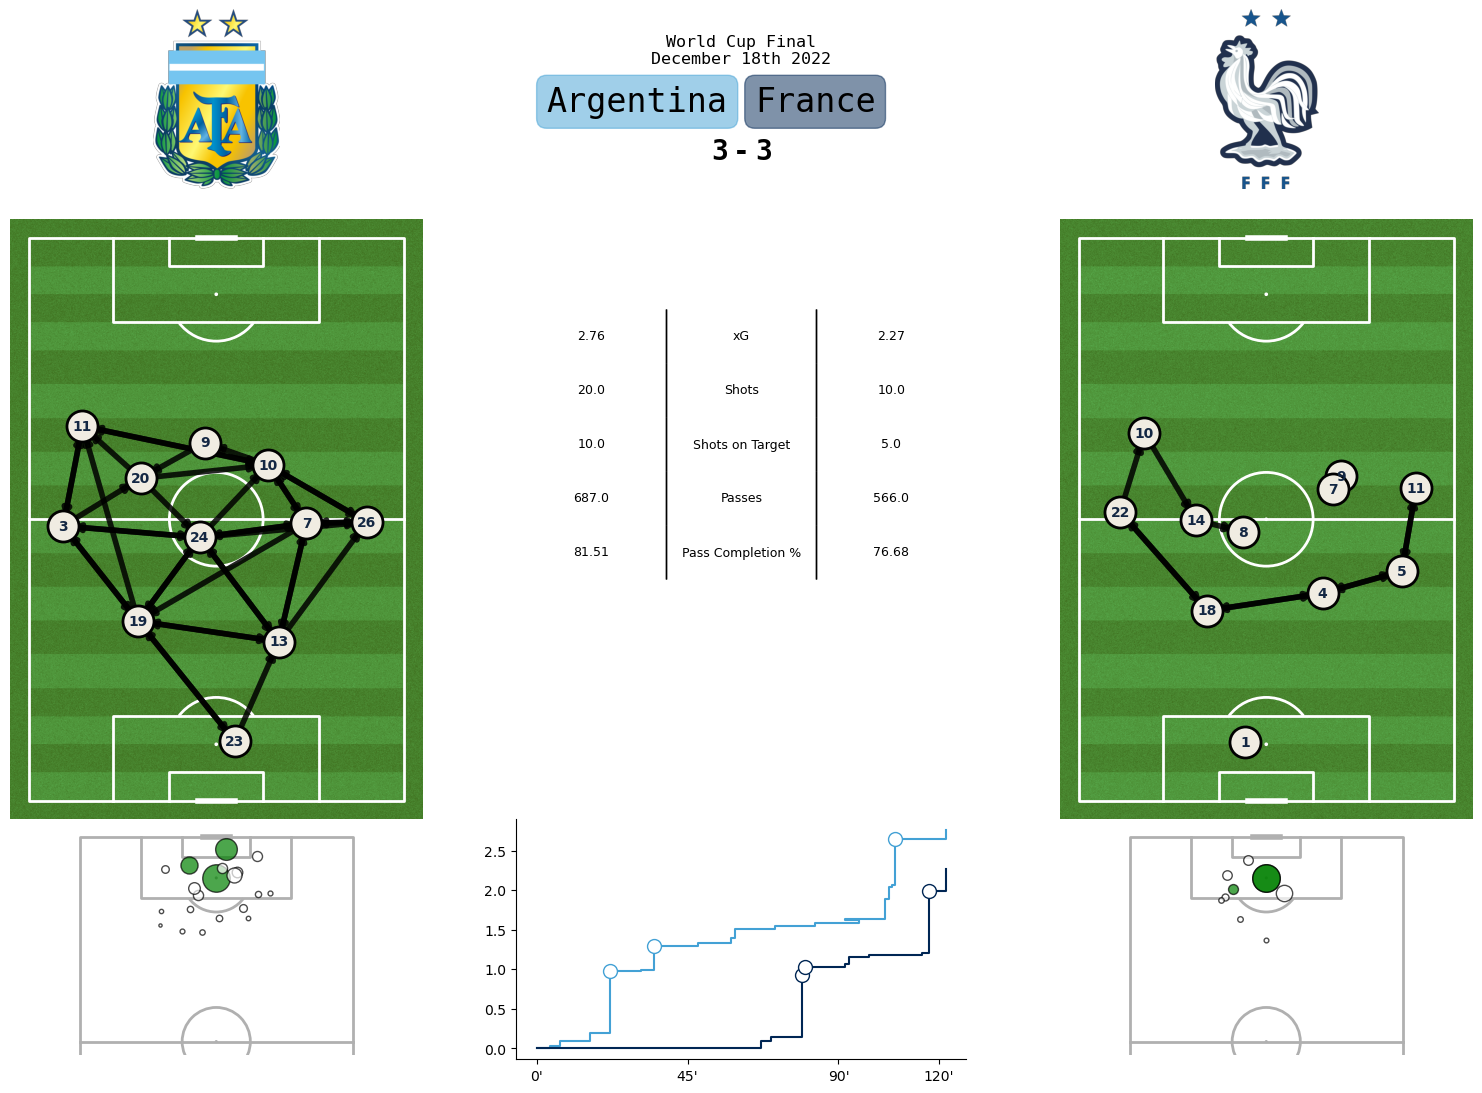

In [124]:
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_axes([.225, .775, .15, .15])

team1_img = Image.open('team_logos/argentina_logo.png')
ax1.imshow(team1_img)
ax1.axis('off')

ax2 = fig.add_axes([.5, .8, .3, .1])

ax2.text(.5, .8, 'World Cup Final\nDecember 18th 2022', fontsize=12, ha='center', fontdict={'family': 'monospace'})

team_1_text = ax2.text(.47, .4, 'Argentina', fontsize=24, ha='right', fontdict={'family': 'monospace'})
team_1_text.set_bbox(dict(facecolor=ARGENTINA_COLOR, alpha=.5, edgecolor=ARGENTINA_COLOR, boxstyle='round'))

team_2_text = ax2.text(.53, .4, 'France', fontsize=24, ha='left', fontdict={'family': 'monospace'})
team_2_text.set_bbox(dict(facecolor=FRANCE_COLOR, alpha=.5, edgecolor=FRANCE_COLOR, boxstyle='round'))

ax2.text(.47, 0, '3', fontsize=20, ha='right', fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(.5, 0, '-', fontsize=20, ha='center', fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(.53, 0, '3', fontsize=20, ha='left', fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.axis('off')

ax3 = fig.add_axes([.925, .775, .15, .15])

team2_img = Image.open('team_logos/france_logo.png')
ax3.imshow(team2_img)
ax3.axis('off')

ax4 = fig.add_axes([.15, .25, .3, .5])
create_passnetwork(team1, ax4)

ax5 = fig.add_axes([.5, .2, .3, .5])
column_labels, table_vals = create_table(team1, team2)

table = ax5.table(
    cellText=table_vals,
    cellLoc='center',
    edges='vertical',
    bbox=[0, .5, 1, .45]
)

table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if j==0:
        table.get_celld()[(i,j)].visible_edges = 'R'
    elif j==2:
        table.get_celld()[(i,j)].visible_edges = 'L'
    else:
        table.get_celld()[(i,j)].visible_edges = 'LR'

ax5.axis('off')

ax6 = fig.add_axes([.85, .25, .3, .5])
create_passnetwork(team2, ax6)

ax7 = fig.add_axes([.2, .05, .2, .2])
create_shotmap(team1, ax7)
ax7.axis('off')

ax8 = fig.add_axes([.5, .05, .3, .2])
create_xg_flow_chart(df, ax8)

ax9 = fig.add_axes([.9, .05, .2, .2])
create_shotmap(team2, ax9)
ax9.axis('off')